In [1]:
import sys
import os
sys.path.append("/home/luke/VIU/09MIAR/src")

from vae.datasets.audio_dataset import AudioDataset
from vae.datasets.mp3_validator import MP3ValidatorDataset
from vae.datasources.fma_datasource import FMADatasource
import torch
from torch.utils.data import DataLoader

from dotenv import load_dotenv
load_dotenv('./VIU/09MIAR/src/vae/.env')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

datasets_path = '/home/luke/VIU/09MIAR/datasets'
valid_files_csv_path = '/home/luke/valid_files.csv'

def get_dataloader(datasets_path, valid_files_csv_path, num_mels):
    fma_dataset = FMADatasource(datasets_path)

    file_paths = fma_dataset.get_file_paths()
    labels = fma_dataset.get_labels()
    mp3Validator = MP3ValidatorDataset(file_paths,labels,valid_files_csv_path,num_mels,10,25,int(os.environ.get('SAMPLE_RATE')))
     
    num_tracks_per_genre, dict_dataset = fma_dataset.balanced(mp3Validator.getValidFiles() ,int(os.environ.get('LIMIT_FILES'))) # TODO: REMOVE -> limited to 500

    file_paths = list(dict_dataset.keys())
    labels = [dict_dataset[fp]['label'] for fp in file_paths]

    dataset = AudioDataset(file_paths, labels)
    print('dataset done')
    
    # dataloader = DataLoader(dataset, int(os.environ.get('TRAIN_BATCH_SIZE')), shuffle=False, drop_last=True, pin_memory=False)
    dataloader = DataLoader(dataset, int(os.environ.get('TRAIN_BATCH_SIZE')), shuffle=True, num_workers=30)
    print('dataloader done')

    return dataloader, dataset

dataloader, dataset = get_dataloader(datasets_path, valid_files_csv_path, int(os.environ.get('NUM_MELS')))


Creating valid_files
done valid_files
dataset done
dataloader done


In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from dotenv import load_dotenv


load_dotenv('./VIU/09MIAR/src/vae/.env')
SAMPLE_RATE = int(os.environ["SAMPLE_RATE"])
N_FFT = int(os.environ["N_FFT"])
HOP_LENGTH = int(os.environ["HOP_LENGTH"])
NUM_MELS = int(os.environ["NUM_MELS"])
SEGMENT_DURATION = int(os.environ["SEGMENT_DURATION"])
LATENT_DIM = int(os.environ["LATENT_DIM"])
NUM_GENRES = int(os.environ["NUM_GENRES"])


SPEC_TIME_STEPS = int((SAMPLE_RATE * SEGMENT_DURATION) / HOP_LENGTH)
print(f"SPEC_TIME_STEPS {SPEC_TIME_STEPS}")


def next_power_of_two(n):
    return 2 ** math.ceil(math.log2(n))

GENRE_EMBEDDING_DIM = next_power_of_two(NUM_GENRES)
print(f"GENRE_EMBEDDING_DIM {GENRE_EMBEDDING_DIM}")

class VAE_Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.genre_embedding = nn.Embedding(NUM_GENRES, GENRE_EMBEDDING_DIM)

        self.conv1 = nn.Conv2d(1 + GENRE_EMBEDDING_DIM, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)

        with torch.no_grad():
            dummy_spec = torch.zeros(1, 1, NUM_MELS, SPEC_TIME_STEPS)
            dummy_genre = torch.zeros(1, dtype=torch.long)
            dummy_emb = self.genre_embedding(dummy_genre).view(1, GENRE_EMBEDDING_DIM, 1, 1).expand(-1, -1, NUM_MELS, SPEC_TIME_STEPS)
            dummy_input = torch.cat([dummy_spec, dummy_emb], dim=1)

            dummy = self.pool(F.relu(self.conv1(dummy_input)))
            dummy = self.pool(F.relu(self.conv2(dummy)))
            dummy = self.pool(F.relu(self.conv3(dummy)))

            self.flattened_shape = dummy.shape[1:]
            self.feature_dim = dummy.numel()

        self.fc_mu = nn.Linear(self.feature_dim, LATENT_DIM)
        self.fc_logvar = nn.Linear(self.feature_dim, LATENT_DIM)

    def forward(self, x, genre):
        x = x[..., :SPEC_TIME_STEPS]
        genre_emb = self.genre_embedding(genre).view(genre.size(0), GENRE_EMBEDDING_DIM, 1, 1)
        genre_emb = genre_emb.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, genre_emb], dim=1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar



class VAE_Decoder(nn.Module):
    def __init__(self, feature_dim, flattened_shape):
        super().__init__()
        self.feature_dim = feature_dim
        self.flattened_shape = flattened_shape

        self.genre_embedding = nn.Embedding(NUM_GENRES, GENRE_EMBEDDING_DIM)
        self.fc = nn.Linear(LATENT_DIM + GENRE_EMBEDDING_DIM, feature_dim)

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
        self.output_pad = nn.ConstantPad2d((0, 5), 0)

    def forward(self, z, genre):
        genre_emb = self.genre_embedding(genre)
        z = torch.cat([z, genre_emb], dim=1)
        x = self.fc(z)
        x = x.view(z.size(0), *self.flattened_shape)


        x = x.permute(0, 2, 1, 3)
        B, H, C, W = x.shape
        x = x.reshape(B * H, C, W).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1).reshape(B, H, C, W)
        x = x.permute(0, 2, 1, 3)

        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        x = self.output_pad(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VAE_Encoder()
        self.decoder = VAE_Decoder(self.encoder.feature_dim, self.encoder.flattened_shape)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, genre):
        mu, logvar = self.encoder(x, genre)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z, genre)
        return x_hat, mu, logvar


class LitVAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = VAE()

    def forward(self, x, genre):
        return self.model(x, genre)

    def training_step(self, batch, batch_idx):
        x, genre = batch
        x = x[..., :SPEC_TIME_STEPS]
        x_hat, mu, logvar = self(x, genre)
        x_hat = x_hat[..., :SPEC_TIME_STEPS]

        if x_hat.shape[-1] != x.shape[-1]:
            min_width = min(x_hat.shape[-1], x.shape[-1])
            x = x[..., :min_width]
            x_hat = x_hat[..., :min_width]

        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        loss = recon_loss + kl_div
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


SPEC_TIME_STEPS 501
GENRE_EMBEDDING_DIM 8


In [ ]:
model = LitVAE()


trainer = pl.Trainer(max_epochs=int(os.environ.get('TRAIN_EPOCHS')))


trainer.fit(model, dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-29 19:30:30.932081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 19:30:30.949553: I tensorflow/core/platform/cpu_feature_guard.cc:210] T

Training: |          | 0/? [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] err

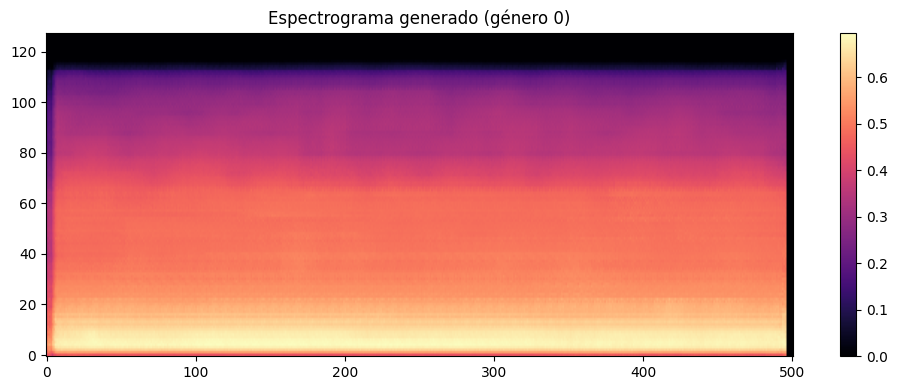

Audio generado guardado en: sample_genre0.wav


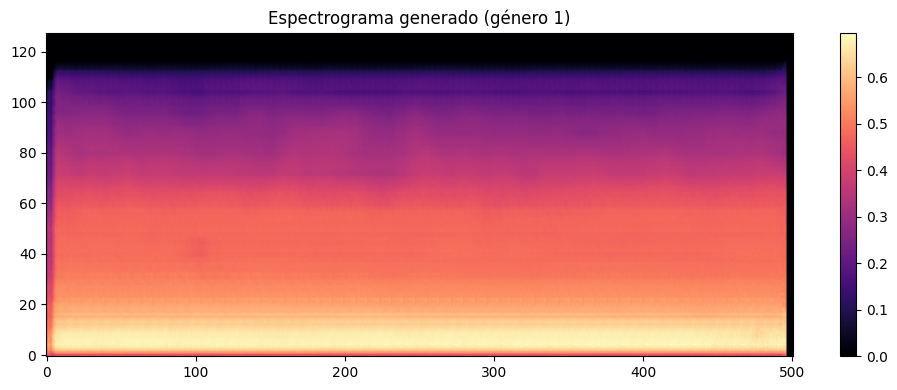

Audio generado guardado en: sample_genre1.wav


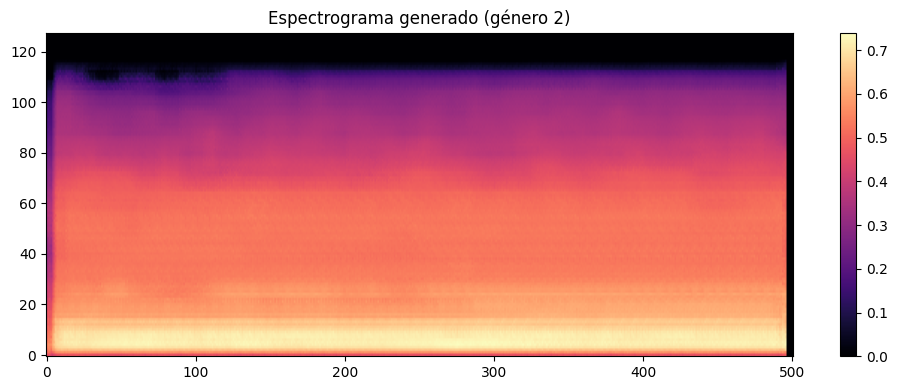

Audio generado guardado en: sample_genre2.wav


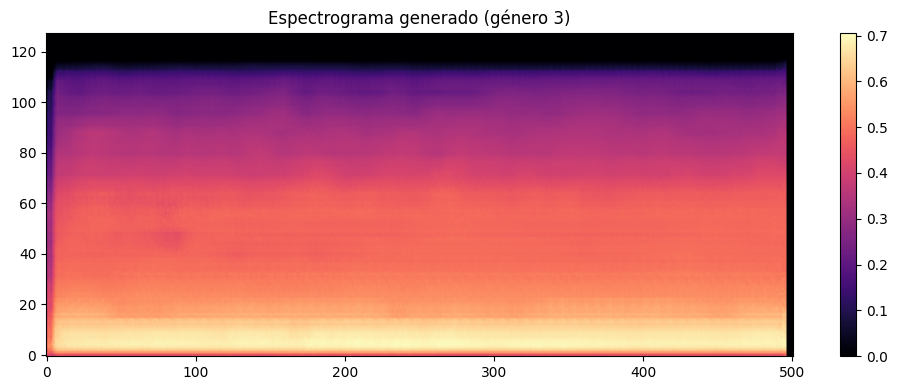

Audio generado guardado en: sample_genre3.wav


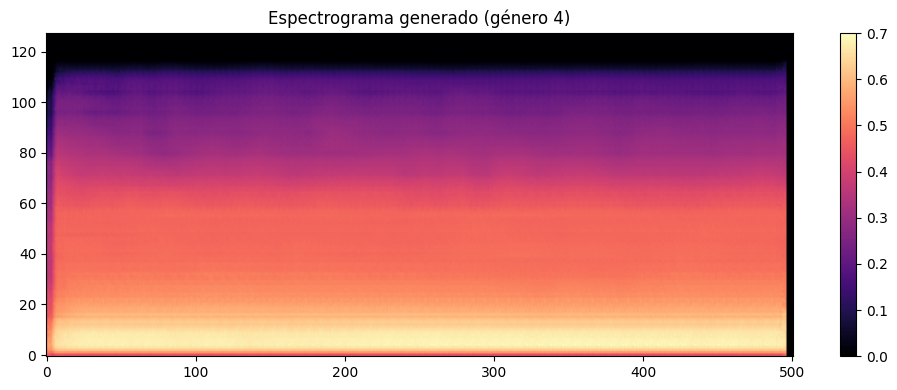

Audio generado guardado en: sample_genre4.wav


IndexError: index out of range in self

In [ ]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt

def generate_audio_from_noise(model: VAE, genre_id: int, output_path: str = "generated.wav"):
    device = model.device
    model = model.model
    model.eval()

    z = torch.randn(1, LATENT_DIM).to(device)
    genre = torch.tensor([genre_id], dtype=torch.long).to(device)

    with torch.no_grad():
        spec = model.decoder(z, genre)

    spec = spec.squeeze().cpu()

    # Visualización
    plt.figure(figsize=(10, 4))
    plt.imshow(spec.numpy(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Espectrograma generado (género {genre_id})")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    inverse_mel = torchaudio.transforms.InverseMelScale(
        n_stft=N_FFT // 2 + 1,
        n_mels=NUM_MELS,
        sample_rate=SAMPLE_RATE,
    )
    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        power=2.0
    )

    spec_db = spec * 80.0 - 80.0
    spec_amp = torch.pow(10.0, spec_db / 20.0)

    spec_amp = spec_amp.unsqueeze(0)
    linear_spec = inverse_mel(spec_amp)
    waveform = griffin_lim(linear_spec)

    torchaudio.save(output_path, waveform, SAMPLE_RATE)
    print(f"Audio generado guardado en: {output_path}")

    return waveform



generate_audio_from_noise(model, genre_id=0, output_path="sample_genre0.wav")
generate_audio_from_noise(model, genre_id=1, output_path="sample_genre1.wav")
generate_audio_from_noise(model, genre_id=2, output_path="sample_genre2.wav")
generate_audio_from_noise(model, genre_id=3, output_path="sample_genre3.wav")
generate_audio_from_noise(model, genre_id=4, output_path="sample_genre4.wav")
generate_audio_from_noise(model, genre_id=7, output_path="sample_genre7.wav")


Shape del batch completo (x): torch.Size([8, 1, 128, 505])
Shape del target (y): torch.Size([8])

Ejemplo individual:
Shape del ejemplo: torch.Size([1, 128, 505])


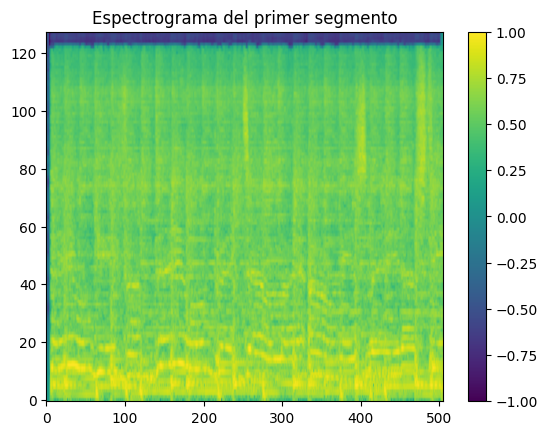

In [ ]:

batch = next(iter(dataloader))

x, y = batch

print("Shape del batch completo (x):", x.shape)
print("Shape del target (y):", y.shape if y is not None else "None")


print("\nEjemplo individual:")
ejemplo = x[0]
print("Shape del ejemplo:", ejemplo.shape)


import matplotlib.pyplot as plt

if ejemplo.ndim == 3:

    plt.imshow(ejemplo.squeeze().cpu(), aspect='auto', origin='lower')
    plt.title("Espectrograma del primer segmento")
    plt.colorbar()
    plt.show()
elif ejemplo.ndim == 4:

    print("Número de segmentos:", ejemplo.shape[0])
    fig, axs = plt.subplots(1, ejemplo.shape[0], figsize=(15, 3))
    for i in range(ejemplo.shape[0]):
        axs[i].imshow(ejemplo[i].squeeze().cpu(), aspect='auto', origin='lower')
        axs[i].set_title(f"Segmento {i+1}")
    plt.show()
else:
    print("Formato no esperado.")
